### ⚙️ Environment Setup
This cell prepares the environment for the notebook by installing required tools and importing core libraries


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pathlib
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
!pip install torchmetrics
from torchmetrics.classification import Precision, Recall, F1Score, Accuracy, ConfusionMatrix
import tqdm
import kagglehub
from collections import Counter
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import Dataset
!pip install torchview



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 20.6 MB/s eta 0:00:00


### 📂 Dataset Download
This block downloads the **Sea Animals Image Dataset** directly from Kaggle using **KaggleHub** and organizes its file path.  
It also prints the dataset structure (number of directories and files) for verification.  


In [2]:
# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")
print("Path to dataset files:", path)
data_path = Path(path)
for (root,dirs,files) in os.walk(path):
  print(f" At {root} Found  {len(dirs)} directories and {len(files)} files")


100%|██████████| 312M/312M [00:03<00:00, 108MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5 Found  23 directories and 0 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Dolphin Found  0 directories and 782 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Clams Found  0 directories and 497 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Shrimp Found  0 directories and 488 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Seal Found  0 directories and 414 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Eel Found  0 directories and 497 files
 At /root/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5/Penguin Found  0 directories and 482 files
 At /root/.

### 💻 Device selection
This code block selects the computation **device** for PyTorch.
It checks if a GPU with CUDA is available; if so, it sets the device to "cuda", otherwise it defaults to "cpu".
Finally, it prints which device is being used.

In [17]:
# set agnostic device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


### 📂 Dataset Preparation & Splitting  

This block loads the dataset, extracts class information, and splits it into training, validation, and test sets with stratification to preserve class balance:  

- **Dataset Loading:** Uses `ImageFolder` to organize images and retrieve class names.  
- **Class Mapping:** Builds a dictionary mapping indices to class labels.  
- **Stratified Split:** Divides the data into **70% training**, **15% validation**, and **15% test**, ensuring balanced label distribution.  
- **Index Dictionaries:** Creates dictionaries for train, validation, and test indices to simplify dataset handling.  
- **Output:** Prints the number of samples in each split for verification.  


In [3]:
full_dataset = ImageFolder(data_path)
class_names = full_dataset.classes
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
lables = full_dataset.targets
indices = range(len(lables))
train_indices, temp_indices = train_test_split(indices, test_size=0.3, stratify=lables, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=[lables[i] for i in temp_indices], random_state=42)
num_classes = len(class_names)

print(f"Train: {len(train_indices)}, Validation: {len(val_indices)}, Test: {len(test_indices)}")

# Spliting indices

train_idx_dict = {i: train_indices[i] for i in range(len(train_indices))}
val_idx_dict = {i: val_indices[i] for i in range(len(val_indices))}
test_idx_dict = {i: test_indices[i] for i in range(len(test_indices))}


Train: 9597, Validation: 2057, Test: 2057


### 📊 Class Distribution Analysis  
This block calculates and displays the distribution of samples across classes in the training, validation, and test sets:  
- **Dataset Lengths:** Counts the number of samples in each split.  
- **Counters:** Uses `Counter` to compute per-class sample counts.  
- **Class Weights:** Normalizes counts by dataset length to derive class weights.  
- **Output:** Prints per-class distribution (absolute count and percentage) for train, validation, and test sets.  


In [4]:
# Count number of samples in each dataset split
train_data_points_len = len(train_indices)
val_data_points_len = len(val_indices)
test_data_points_len = len(test_indices)

# Initialize weight vectors for each split
weight_classes_train = []
weight_classes_val = []
weight_classes_test = []

# Count per-class samples for each split
train_counter = Counter([lables[i] for i in train_indices])
val_counter = Counter([lables[i] for i in val_indices])
test_counter = Counter([lables[i] for i in test_indices])

# Training set distribution
print("Class Distribution in Train Set:")
for class_idx, class_name in enumerate(class_names):
    count_train = train_counter[class_idx]                     # sample count
    class_weight = count_train / train_data_points_len         # normalized weight
    weight_classes_train.append(class_weight)
    percentage = class_weight * 100
    print(f"- {class_name:<15} {count_train:>5} samples ({percentage:.2f}%)")
print("Total = ", train_data_points_len, "\n\n")

# Validation set distribution
print("Class Distribution in Validation Set:")
for class_idx, class_name in enumerate(class_names):
    count_val = val_counter[class_idx]
    class_weight = count_val / val_data_points_len
    weight_classes_val.append(class_weight)
    percentage = class_weight * 100
    print(f"- {class_name:<15} {count_val:>5} samples ({percentage:.2f}%)")
print("Total = ", val_data_points_len, "\n\n")

# Test set distribution
print("Class Distribution in Test Set:")
for class_idx, class_name in enumerate(class_names):
    count_test = test_counter[class_idx]
    class_weight = count_test / test_data_points_len
    weight_classes_test.append(class_weight)
    percentage = class_weight * 100
    print(f"- {class_name:<15} {count_test:>5} samples ({percentage:.2f}%)")
print("Total = ", test_data_points_len, "\n")

# Sanity check: weights should sum to 1
print()
print(f"Train Sum of weights = {sum(weight_classes_train)}")
print(f"Val Sum of weights = {sum(weight_classes_val)}")
print(f"Test Sum of weights = {sum(weight_classes_test)}")




Class Distribution in Train Set:
- Clams             348 samples (3.63%)
- Corals            350 samples (3.65%)
- Crabs             349 samples (3.64%)
- Dolphin           547 samples (5.70%)
- Eel               348 samples (3.63%)
- Fish              346 samples (3.61%)
- Jelly Fish        592 samples (6.17%)
- Lobster           349 samples (3.64%)
- Nudibranchs       350 samples (3.65%)
- Octopus           393 samples (4.10%)
- Otter             350 samples (3.65%)
- Penguin           337 samples (3.51%)
- Puffers           372 samples (3.88%)
- Sea Rays          362 samples (3.77%)
- Sea Urchins       405 samples (4.22%)
- Seahorse          335 samples (3.49%)
- Seal              290 samples (3.02%)
- Sharks            413 samples (4.30%)
- Shrimp            342 samples (3.56%)
- Squid             338 samples (3.52%)
- Starfish          349 samples (3.64%)
- Turtle_Tortoise  1332 samples (13.88%)
- Whale             400 samples (4.17%)
Total =  9597 


Class Distribution in Validat

### 🔍 Visualizing Sample Images  
In this block, we randomly select 6 images from the dataset and display them in a 3×2 grid.  
Each image is shown along with its class label, allowing us to quickly inspect the dataset quality, class diversity, and confirm that the images are being correctly loaded and mapped to their categories.


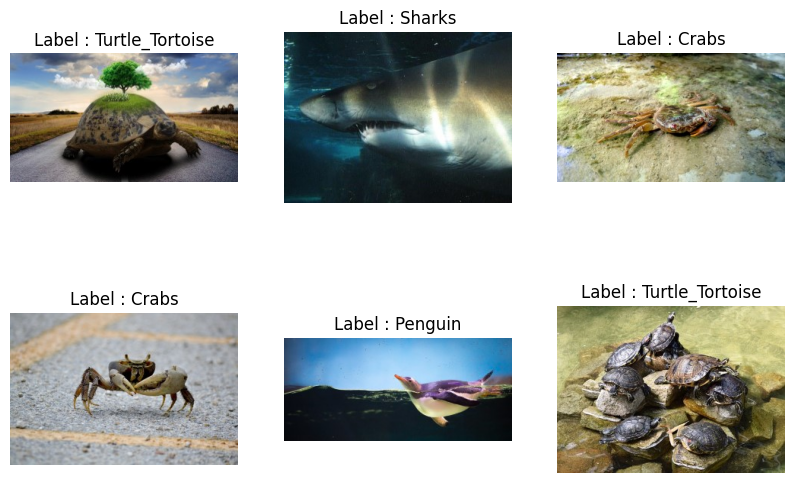

In [5]:
# Visualising the images
rnd_indices = random.sample(range(len(full_dataset)), 6)
plt.figure(figsize=(10,10))
for idx in range(len(rnd_indices)):
  plt.subplot(3,3,idx+1)
  img , label = full_dataset[rnd_indices[idx]]
  plt.imshow(img)
  plt.title(f"Label : {idx_to_class[label]}")
  plt.axis("off")
plt.show()

### 🛠️ Data Transformations  
This block defines preprocessing pipelines for training, validation, and test sets:  
- **Training Transform:** Resize to 224×224, apply random horizontal flip, convert to tensor, and normalize with ImageNet statistics.  
- **Validation Transform:** Same as training, including random horizontal flip, to check robustness during validation.  
- **Test Transform:** Resize and normalize without augmentation, ensuring consistent evaluation.  


In [6]:
# Training data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                           # resize images
    transforms.RandomHorizontalFlip(p=0.5),                  # random flip for augmentation
    transforms.ToTensor(),                                   # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # normalize (ImageNet stats)
                         std=[0.229, 0.224, 0.225])
])

# Validation data transformations
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),                  # keep same augmentation as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test data transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### 🧱 Custom Dataset & DataLoaders  
This block defines a lightweight dataset wrapper over `ImageFolder` and creates data loaders for each split:  
- **Custom Dataset:** Wraps a base dataset and exposes a subset via provided indices; applies an optional `transform` per sample.  
- **Safe Indexing:** Supports both lists of indices and dicts that map 0..N-1 → original indices.  
- **Item Access:** Retrieves `(image, label)` from the base dataset and applies the split-specific transform.  
- **DataLoaders:** Batches data (32), shuffles only the training set, and keeps validation/test deterministic.  
- **Outcome:** Ready-to-use `train/val/test` PyTorch `DataLoader`s.


In [7]:
class custom_dataset(Dataset):
    def __init__(self, full_dataset, indices, transform=None):
        super().__init__()
        self.full_dataset = full_dataset
        self.indices = indices
        self.transform = transform

        # Pre-compute labels for the subset (works for list or dict indices)
        if isinstance(self.indices, dict):
            base_idxs = list(self.indices.values())
        else:
            base_idxs = list(self.indices)
        self.lables = [self.full_dataset[i][1] for i in base_idxs]  # class ids for the subset

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        # Resolve base index (supports dict or list)
        base_idx = self.indices[index] if isinstance(self.indices, dict) else self.indices[index]
        image, label = self.full_dataset[base_idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Build split datasets
train_dataset = custom_dataset(full_dataset, train_idx_dict, transform=train_transform)
val_dataset   = custom_dataset(full_dataset, val_idx_dict,   transform=val_transform)
test_dataset  = custom_dataset(full_dataset, test_idx_dict,  transform=test_transform)

# Construct data loaders (shuffle only train)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_data_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


### 🏗️ Model Setup (ResNet50)  
This block initializes a ResNet50 model and adapts it for the custom classification task:  
- **Load Pretrained Model:** Loads ResNet50 with ImageNet pretrained weights.  
- **Freeze Parameters:** Disables gradient updates for all layers to retain pretrained features.  
- **Custom Classifier:** Replaces the fully connected (FC) layer with a new `Linear` layer sized to the number of dataset classes.  




In [8]:
# Load ResNet50 with pretrained ImageNet weights and move to device
rs_net_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

# Freeze all model parameters (no gradients for feature extractor)
for param in rs_net_model.parameters():
    param.requires_grad = False

# Replace final fully connected layer with custom classifier
in_features = rs_net_model.fc.in_features
rs_net_model.fc = nn.Linear(in_features, len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 51.4MB/s]


### 🎯 Training & Evaluation Loops  
This block defines reusable functions for training and evaluating the model:  
- **`train_step`:** Runs one epoch of training; computes loss/accuracy, performs backpropagation, and updates weights.  
- **`test_step`:** Evaluates the model on validation/test data without gradient updates, returning average loss/accuracy.  
- **`train_model`:** Manages the full training process over multiple epochs, logs metrics, tracks the best model state, and prints progress.  
- **Outcome:** Returns training history (`results`) and the best-performing model weights.  
- **Training monitoring:** Plots accuracy and loss curves (train vs. validation) across epochs for performance visualization.  


In [15]:
import matplotlib.pyplot as plt

def train_step(model, data_loader, loss_fn, acc_fn, optimizer, device):
    model.train()  # enable training-specific layers (e.g., dropout, BN)
    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in enumerate(data_loader):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)

        # Metrics
        train_loss += loss.item()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(y_pred, y).item()

        # Backward pass + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Averages over all batches
    train_loss /= len(data_loader)
    train_acc  /= len(data_loader)
    return train_loss, train_acc


def test_step(model, data_loader, loss_fn, acc_fn, device):
    test_loss, test_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            # Metrics
            preds = torch.softmax(logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(preds, y).item()

    # Averages over all batches
    test_loss /= len(data_loader)
    test_acc  /= len(data_loader)
    return test_loss, test_acc


def train_model(model, train_data_loader, test_data_loader, optimizer, loss_fn, acc_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_model_state_dict = {}
    best_val_acc = -1.0

    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}")

        # Training
        train_loss, train_acc = train_step(model, train_data_loader, loss_fn, acc_fn, optimizer, device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        # Validation
        test_loss, test_acc = test_step(model, test_data_loader, loss_fn, acc_fn, device)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Track best model by validation accuracy
        if test_acc > best_val_acc:
            best_val_acc = test_acc
            best_model_state_dict = model.state_dict()

        print(
            f"At epoch {epoch+1}: "
            f"Train loss {train_loss:.4f}, Train acc {train_acc:.4f}, "
            f"Val loss {test_loss:.4f}, Val acc {test_acc:.4f}"
        )

    # --- Plots ---
    epochs_range = range(1, epochs + 1)

    # 1) Accuracy vs. Epochs (y in [0,1])
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, results["train_acc"], label="Train Accuracy")
    plt.plot(epochs_range, results["test_acc"],  label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.ylim(0, 1)  # force y-axis to [0,1]
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # 2) Loss vs. Epochs (y in [0,1])  — may clip if your loss > 1
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, results["train_loss"], label="Train Loss")
    plt.plot(epochs_range, results["test_loss"],  label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.ylim(0, 1)  # force y-axis to [0,1] as requested
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return results, best_model_state_dict


### ⚙️ Training Configuration & Execution  
This block configures the optimizer and metrics, launches training, and restores the best-performing weights:  
- **Optimizer:** Adam over model parameters with learning rate `1e-3`.  
- **Loss:** `CrossEntropyLoss` for multi-class classification (weighted loss).  
- **Metric:** `Accuracy` (multiclass) tracked on the selected device.  
- **Training:** Runs `train_model` over the specified epochs using train/val loaders.  
- **Checkpointing:** Loads back the best state dict (by highest validation accuracy).  


Starting epoch 1
At epoch 1: Train loss 0.2018, Train acc 0.9257, Val loss 0.4605, Val acc 0.8372
Starting epoch 2
At epoch 2: Train loss 0.1847, Train acc 0.9322, Val loss 0.4817, Val acc 0.8230


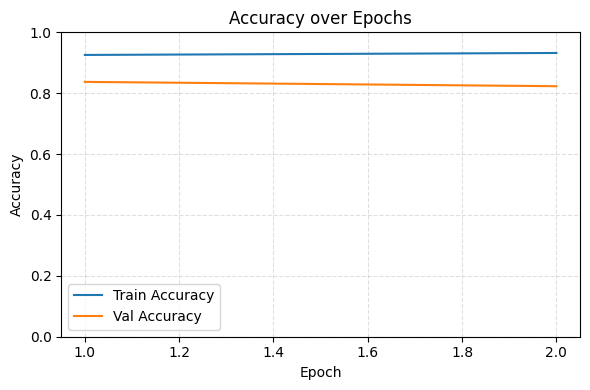

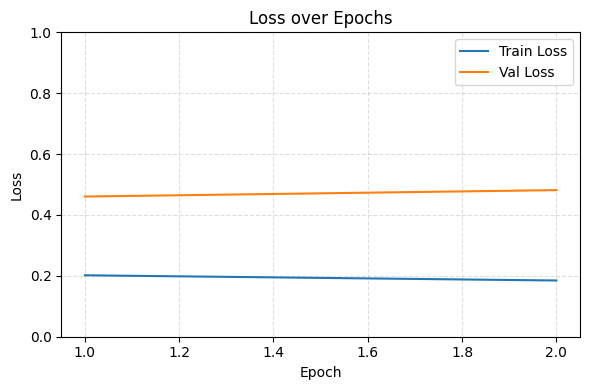

<All keys matched successfully>

In [16]:
# Define Params
optimizer = torch.optim.Adam(rs_net_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weight_classes_train).to(device))
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)
epochs = 15

# Train and select best model by validation accuracy
results , best_model_state_dict = train_model(rs_net_model, train_data_loader, val_data_loader, optimizer, loss_fn, acc_fn, epochs, device = device)

# Restore best-performing weights
rs_net_model.load_state_dict(best_model_state_dict)

### 📈 Model Inference on Test Set  
This block evaluates the trained model on the held-out test data:  
- **Evaluation Mode:** Sets the model to `eval` to disable dropout/batchnorm updates.  
- **No Gradients:** Uses `torch.inference_mode()` for efficient forward passes.  
- **Predictions:** Computes logits, converts to probabilities via softmax, and selects class predictions.  
- **Storage:** Collects ground-truth labels, predicted labels, and probability distributions for all batches.  
- **Final Outputs:** Concatenates results into `y_true` and `y_pred` tensors on the active device.  


In [ ]:
# Switch model to evaluation mode
rs_net_model.eval()

all_preds, all_probs, all_truth = [], [], []

# Disable gradient calculation for inference
with torch.inference_mode():
    for X, y in test_data_loader:
        X, y = X.to(device), y.to(device)

        logits = rs_net_model(X)             # forward pass
        probs = torch.softmax(logits, dim=1) # probabilities
        preds = torch.argmax(probs, dim=1)   # predicted classes

        all_truth.append(y)
        all_preds.append(preds)
        all_probs.append(probs)

# Concatenate predictions, probabilities, and labels
y_true = torch.cat(all_truth).to(device)
y_pred = torch.cat(all_preds).to(device)


📈 **Model Evaluation & Metrics**  
This block defines and computes **classification metrics** for a multiclass problem, including:  
- **Accuracy, Precision, Recall, and F1-Score** (macro-averaged).  
- **Per-class metrics** for each category.  

The metrics are **printed in summary** and also **detailed per class**


In [ ]:
# Define evaluation metrics (global and per-class)
acc_metric         = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_macro    = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_macro       = Recall(   task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_macro           = F1Score( task="multiclass", num_classes=num_classes, average="macro").to(device)

acc_perclass       = Accuracy(task="multiclass", num_classes=num_classes, average=None).to(device)
precision_perclass = Precision(task="multiclass", num_classes=num_classes, average=None).to(device)
recall_perclass    = Recall(   task="multiclass", num_classes=num_classes, average=None).to(device)
f1_perclass        = F1Score( task="multiclass", num_classes=num_classes, average=None).to(device)

confmat_metric     = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

# Compute global metrics
acc_val = acc_metric(y_pred, y_true).item()
prec_m  = precision_macro(y_pred, y_true).item()
rec_m   = recall_macro(y_pred, y_true).item()
f1_m    = f1_macro(y_pred, y_true).item()

# Compute per-class metrics
acc_perclass = acc_perclass(y_pred, y_true).detach().cpu().numpy()
prec_pc      = precision_perclass(y_pred, y_true).detach().cpu().numpy()
rec_pc       = recall_perclass(y_pred, y_true).detach().cpu().numpy()
f1_pc        = f1_perclass(y_pred, y_true).detach().cpu().numpy()


# Print global metrics
print(f"Accuracy : {acc_val:.4f}")
print(f"Precision: {prec_m:.4f}")
print(f"Recall   : {rec_m:.4f}")
print(f"F1-Score : {f1_m:.4f}\n")

# Print per-class metrics
print("Per-class metrics:")
for i, cls in enumerate(class_names):
    print(cls)
    print(f"Accuracy={acc_perclass[i]} Precision={prec_pc[i]} Recall={rec_pc[i]} F1_Score={f1_pc[i]}\n")



📈 **Confusion Matrix**  
Provides deeper insight into the types of mistakes made by the model.  


In [ ]:
# Compute confusion matrix
conf_mat = confmat_metric(y_pred, y_true).detach().cpu().numpy()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6 + num_classes*0.3, 5 + num_classes*0.3))
im = ax.imshow(conf_mat, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(num_classes),
    yticks=np.arange(num_classes),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (Test)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate confusion matrix cells
thresh = conf_mat.max() / 2.0 if conf_mat.size else 0
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, int(conf_mat[i, j]), ha="center", va="center",
                color="white" if conf_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
